# Make Plots
Plots related to the large molecule size tests

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from jcesr_ml.style import model_style
from ase.units import Hartree, eV
from scipy.stats import sem
import pandas as pd
import numpy as np
import os

## Load in Results
We'll need the predictions of FCHL/SchNet on large molecules, and on the QM9 test set

In [2]:
large_data = pd.read_csv('large-molecule-predictions.csv')

In [3]:
schnet_predictions = pd.read_csv(os.path.join('..', 'benchmark', 'schnet', 'schnet_predictions.csv.gz'))

In [4]:
fchl_predictions = pd.read_csv(os.path.join('..', 'benchmark', 'qml', 'fchl-predictions.csv.gz'))

## Make a Histogram of Errors on Large Molecules
Compare B3LYP/FCHL/SchNet

MAE B3LYP: 439.12 meV
MAE g4mp2-delta: 39.43 meV
MAE FCHL Delta: 19.70 meV


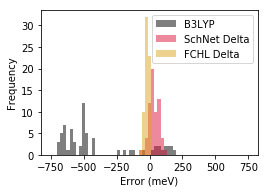

In [5]:
fig, ax = plt.subplots()

bins = np.linspace(-750, 750, 64)

# Plot B3LYP
error = (large_data['g4mp2_atom'] - large_data['u0_atom']) * Hartree / eV * 1000
print('MAE B3LYP: {:.2f} meV'.format(error.abs().mean()))
ax.hist(error, bins=bins, alpha=0.5, color=model_style['B3LYP']['color'],
       label=model_style['B3LYP']['label'])


# Plot the SchNet models
for m in ['g4mp2-delta']:
    error = (large_data['g4mp2_0k-pred-{}'.format(m)] - large_data['g4mp2_0k']) * Hartree / eV * 1000
    print('MAE {}: {:.2f} meV'.format(m, error.abs().mean()))
    ax.hist(error, bins=bins, alpha=0.5, color=model_style[m]['color'],
           label=model_style[m]['label'])
    
# Add FCHL
error = (large_data['g4mp2_atom'] - large_data['u0_atom'] 
         - large_data['g4mp2_0k-pred-fchl-delta']) * Hartree / eV * 1000
print('MAE {}: {:.2f} meV'.format('FCHL Delta', error.abs().mean()))
ax.hist(error, bins=bins, alpha=0.5, color=model_style['FCHL Delta']['color'],
       label=model_style['FCHL Delta']['label'])

# Make it pretty
ax.set_xlabel('Error (meV)')
ax.set_ylabel('Frequency')

ax.legend()
fig.tight_layout()
fig.set_size_inches(3.5, 2.5)
fig.savefig(os.path.join('figures', 'large-mol-hist.png'), dpi=320)

## Make Molecule Size Plot for Generated Coordinates
Show how large the errors are and that they increase with molecule size

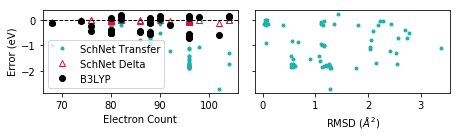

In [6]:
fig, axs = plt.subplots(1, 2, sharey=True)

ax = axs[0]
# Plot the SchNet Predictions
error = (large_data['g4mp2_0k'] - large_data['g4mp2_0k-pred-schnet-smiles']) * Hartree / eV
ax.plot(large_data['n_electrons'], error, **model_style['g4mp2-transfer'], linewidth=0)

error = (large_data['g4mp2_0k'] - large_data['g4mp2_0k-pred-g4mp2-delta']) * Hartree / eV
ax.plot(large_data['n_electrons'], error, **model_style['g4mp2-delta'], linewidth=0)

error = (large_data['g4mp2_atom'] - large_data['u0_atom']) * Hartree / eV
ax.plot(large_data['n_electrons'], error, **model_style['B3LYP'], linewidth=0)

# Add in the zero line
xlim = ax.set_xlim(ax.get_xlim())
ax.plot(xlim, [0,0], 'k--', lw=1)

ax.set_xlabel('Electron Count')
ax.set_ylabel('Error (eV)')

ax.legend(loc='lower left')

# Plot the RMSD vs Error
ax = axs[1]
error = (large_data['g4mp2_0k'] - large_data['g4mp2_0k-pred-schnet-smiles']) * Hartree / eV
ax.plot(large_data['rmsd'], error, **model_style['g4mp2-transfer'], linewidth=0)
ax.set_xlabel('RMSD ($\\AA^2$)')


fig.set_size_inches(6.5, 2)
fig.tight_layout()
fig.savefig(os.path.join('figures', 'large-molecules-generated.png'), dpi=320)
fig.savefig(os.path.join('figures', 'large-molecules-generated.pdf'))

## Make Molecule Size Dependence Plot for $\Delta$ Models
Plot the errors for different numbers of heavy atoms

Compute the errors

In [7]:
model_style['B3LYP']['color'] = '#909090'

0.002217727960993813
0.0015510490033398812
0.003001027144503478
0.0028473004830919463
0.002437068224078711
0.002960405939113239
0.004778377742712658


/home/wardlt/miniconda3/envs/g4mp2_ml/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/wardlt/miniconda3/envs/g4mp2_ml/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


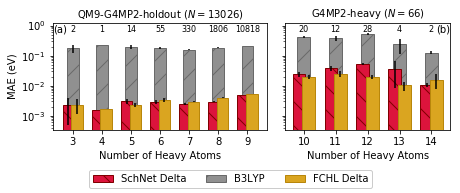

In [8]:
fig, axs = plt.subplots(1, 2, sharey=True, gridspec_kw={'width_ratios': [1.3, 1]})
fig.set_size_inches(6.5, 2.7)
num_level = 0.6

# Add the QM9 test data to the plot
ax = axs[0]
for gid, group in schnet_predictions.groupby('n_heavy_atoms'):
    errors = (group['u0_atom'] - group['g4mp2_atom']).abs() * Hartree / eV
    b3lyp_hdl = ax.bar([gid], [errors.mean()], color=model_style['B3LYP']['color'], yerr=sem(errors),
                       width=0.4, edgecolor='dimgray', hatch='/')
    
    errors = (group['g4mp2_0k'] - group['ypred-g4mp2-delta-117232']).abs() * Hartree / eV
    schnet_hdl = ax.bar([gid-0.15], [errors.mean()], color=model_style['g4mp2-delta']['color'], yerr=sem(errors),
                        width=0.4, edgecolor='maroon', hatch='\\')
    print(errors.mean())
    
    ax.text(gid, num_level, len(group), fontsize=8, ha='center')

for gid, group in fchl_predictions.groupby('n_heavy_atoms'):
    errors = (group['delta'] - group['pred_y_10000-delta']).abs() * Hartree / eV
    fchl_hdl = ax.bar([gid+0.15], [errors.mean()], color=model_style['FCHL Delta']['color'], yerr=sem(errors),
                      width=0.4, edgecolor='darkgoldenrod')
    
# Add the large molecules to the dataset
ax = axs[1]
for gid, group in large_data.groupby('n_heavy_atoms'):
    errors = (group['u0_atom'] - group['g4mp2_atom']).abs() * Hartree / eV
    ax.bar([gid], [errors.mean()], color=model_style['B3LYP']['color'], yerr=sem(errors),
           width=0.4, edgecolor='dimgray', hatch='/')
    
    errors = (group['g4mp2_0k'] - group['g4mp2_0k-pred-g4mp2-delta']).abs() * Hartree / eV
    ax.bar([gid-0.15], [errors.mean()], color=model_style['g4mp2-delta']['color'], yerr=sem(errors),
           width=0.4, edgecolor='maroon', hatch='\\')
    
    errors = (group['g4mp2_atom'] - group['u0_atom'] - group['g4mp2_0k-pred-fchl-delta']).abs() * Hartree / eV
    ax.bar([gid+0.15], [errors.mean()], color=model_style['FCHL Delta']['color'], yerr=sem(errors), width=0.4, edgecolor='darkgoldenrod')
    
    ax.text(gid, num_level, len(group), fontsize=8, ha='center')

# Make the ticks
min_n = schnet_predictions['n_heavy_atoms'].min()
axs[0].set_xticks(range(min_n, 10))
axs[1].set_xticks(range(10, 15, 1))

# Make axes titles
axs[0].set_title('QM9-G4MP2-holdout ($N={}$)'.format(len(schnet_predictions)), fontsize=10)
axs[1].set_title('G4MP2-heavy ($N={}$)'.format(len(large_data)), fontsize=10)

# Add labels
axs[0].text(0, 0.99, '(a)', transform=axs[0].transAxes, ha='left', va='top')
axs[1].text(1, 0.99, '(b)', transform=axs[1].transAxes, ha='right', va='top')

# Make the y axis log, and have a second one with kcal/mol (not right now)
ax.set_yscale('log')
ax.set_ylim(min(ax.get_ylim()), 1.2)
#for i, ax in enumerate(axs):
#    ax2 = ax.twinx()
#    ax2.set_yscale('log')
#    ax2.set_ylim(np.multiply(0.02306055, ax.get_ylim()))
#    if i == 0:
#        ax2.set_yticklabels([])

# Make the lend
fig.legend((schnet_hdl, b3lyp_hdl, fchl_hdl), ('SchNet Delta', 'B3LYP', 'FCHL Delta'), loc='lower center', ncol=3, framealpha=1)

for ax in axs:
    ax.set_xlabel('Number of Heavy Atoms')
axs[0].set_ylabel('MAE (eV)')
#ax2.set_ylabel('MAE (kcal/mol)')

fig.tight_layout(rect=[0, 0.1, 1, 1])
fig.savefig(os.path.join('figures', 'heavy-atom-hist.png'), dpi=320)
fig.savefig(os.path.join('figures', 'heavy-atom-hist.pdf'))